# ROMY Event Catalog

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
config = {}

## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

## minimal magnitude
config['minmagnitude'] = 6.0

## first region specified
config['minlatitude'] = -90
config['maxlatitude'] = 90
config['minlongitude'] = -180
config['maxlongitude'] = 180

config['eventfile'] = "ROMY_global_catalog"


config['tbeg'] = obs.UTCDateTime("2020-01-01")
config['tend'] = obs.UTCDateTime("2023-12-31")


config['outpath'] = data_path+"romy_events/data/catalogs/"
# config['outpath'] = "./data/"

config['outpath_figs'] = data_path+"romy_events/figures/"

## adjust eventfile name
config['eventfile'] += f"_{str(config['tbeg'].date).replace('-','')}"
config['eventfile'] += f"_{str(config['tend'].date).replace('-','')}"

config['str_dates'] = f"{str(config['tbeg'].date).replace('-','')}_{str(config['tend'].date).replace('-','')}"

In [4]:
from functions.catalog_to_dataframe import __catalog_to_dataframe
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

In [5]:
def __export_new_events(config, events_old, events):
    
    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)
    
    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")
    
    del tmp, df  

## Get Events

In [6]:
client = Client("ISC")

## events - all in area and time period
events = client.get_events(
                           minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                           minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                           minmagnitude=config['minmagnitude'],
                           starttime=config['tbeg'], endtime=config['tend'],
                           )

In [7]:
print(f" -> storing: {config['outpath']}{config['eventfile']}.xml")
events.write(config['outpath']+config['eventfile']+".xml", format="QUAKEML")

 -> storing: /home/andbro/kilauea-data/romy_events/data/catalogs/ROMY_global_catalog_20200101_20231231.xml


### converting to dataframe

In [8]:
## convert catalog object to data frame
events_df = __catalog_to_dataframe(events)

events_df = events_df.rename_axis('timestamp').reset_index()
events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
events_df

,timestamp,latitude,longitude,depth,magnitude,type,seconds
0,2020-01-06 10:32:19.160,17.7486,-66.8286,8079.8,5.95,mb,0.000000e+00
1,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04
2,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04
3,2020-01-09 08:38:08.890,62.2654,171.0078,8959.8,5.97,mb,2.523497e+05
4,2020-01-19 13:27:57.850,39.7669,77.1324,10361.2,5.78,mb,1.133739e+06
...,...,...,...,...,...,...,...
1100,2023-12-20 12:11:22.030,-16.0280,-72.5450,94900.0,6.00,M,1.247675e+08
1101,2023-12-23 17:48:05.220,52.0190,159.0030,36100.0,5.98,M,1.250469e+08
1102,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08
1103,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08


### add distances and backazimuth

In [9]:
## add epicentral distances
__add_distances_and_backazimuth(config, events_df)

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km
0,2020-01-06 10:32:19.160,17.7486,-66.8286,8079.8,5.95,mb,0.000000e+00,273.611213,7683.547502
1,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04,91.926528,9456.374129
2,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04,273.629169,7675.920763
3,2020-01-09 08:38:08.890,62.2654,171.0078,8959.8,5.97,mb,2.523497e+05,9.987013,7629.287864
4,2020-01-19 13:27:57.850,39.7669,77.1324,10361.2,5.78,mb,1.133739e+06,74.622163,5202.291787
...,...,...,...,...,...,...,...,...,...
1100,2023-12-20 12:11:22.030,-16.0280,-72.5450,94900.0,6.00,M,1.247675e+08,254.883009,10872.229523
1101,2023-12-23 17:48:05.220,52.0190,159.0030,36100.0,5.98,M,1.250469e+08,19.778726,8487.701245
1102,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08,29.127618,8935.182118
1103,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08,29.034678,8953.123325


### store catalogs

In [10]:
## write data frame as pickle file
events_df.to_pickle(config['outpath']+config['eventfile']+".pkl")

## Request Focal Mechanisms

In [11]:
from functions.request_CMT_events import __request_CMT_events

# !rm /import/kilauea-data/BSPF/data/catalogs/gcmt_solutions_20221001_20230930.xml

__request_CMT_events(starttime=config['tbeg'], endtime=config['tend'], outtype="QUAKEML", outfile=config['outpath']+f"gcmt_solutions_{config['str_dates']}.xml")

# cgmt = obs.read_events(config['outpath']+'gcmt_solutions_{config['str_dates']}.xml')

 -> file: /home/andbro/kilauea-data/romy_events/data/catalogs/gcmt_solutions_20200101_20231231.xml already exists!


## Plot Event Timeline

In [12]:
def __plot_timeline(catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    cmap = plt.get_cmap('viridis', 7)

    cax = ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=2**catalog_all_df.magnitude,
                     c=catalog_all_df.magnitude, alpha=0.6, cmap=cmap)


    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label("Magnitude", fontsize=14)
    cax.set_clim(6, 9.5)

    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)

#     ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())
    ax.set_xlim(config['tbeg']-4*86400, config['tend']+4*86400)

#     ax.set_title(f"Events={len(catalog_df)}")
    ax.text(config['tend']-140*86400, catalog_all_df.distances_km.max(), f"Events={len(catalog_all_df)}")

    plt.show();
    return fig

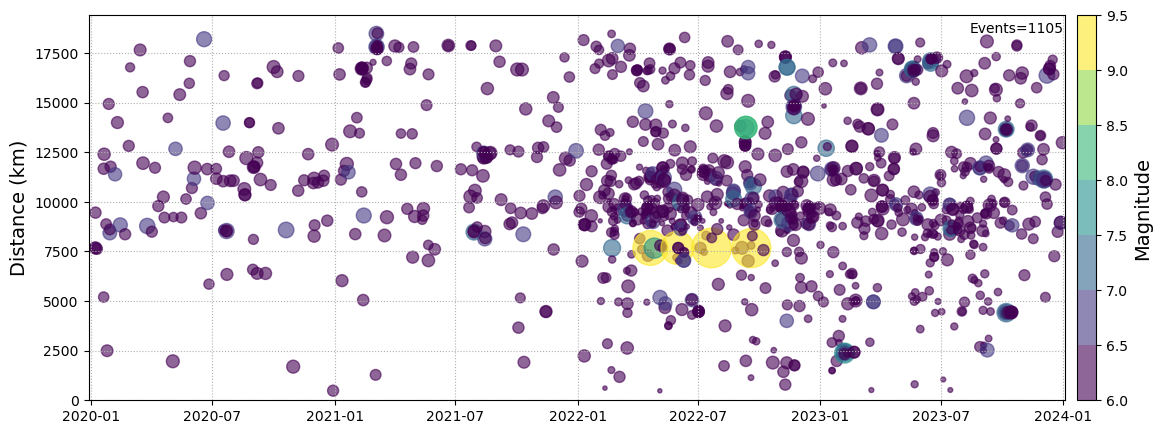

In [13]:
fig = __plot_timeline(events_df)

# fig.savefig(config['outpath_figs']+f"Plot_timeline_{config['eventfile']}_{config['str_dates']}.png", dpi=200, bbox_inches="tight", pad_inches=0.05)


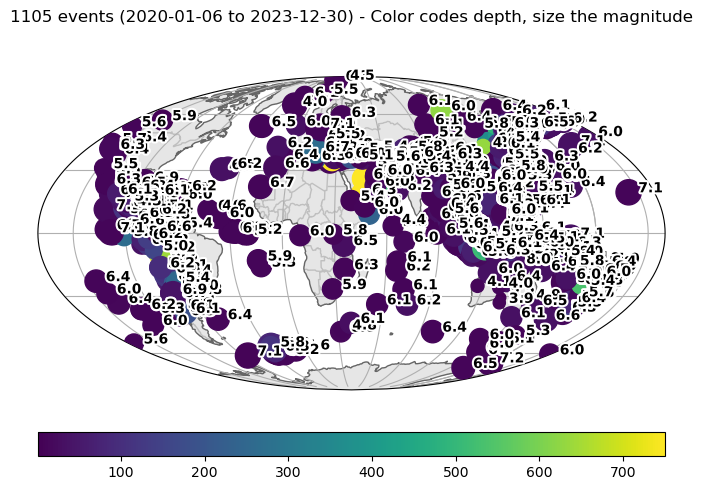

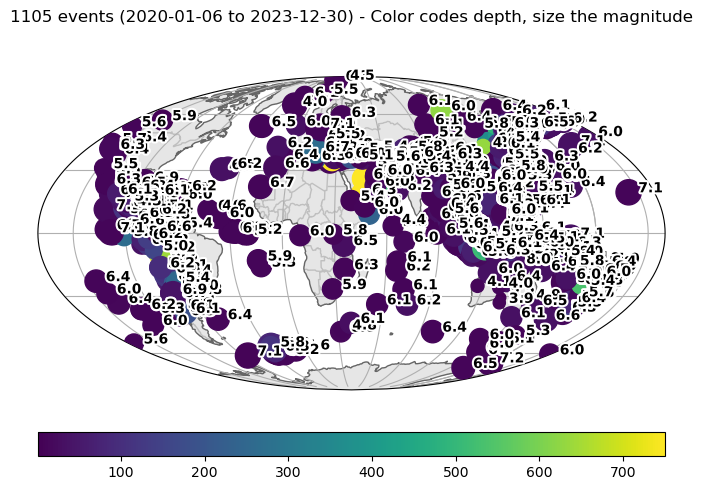

In [14]:
events.plot();